In [2]:
#%matplotlib notebook
import sys
import os

# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

# Tools specific for this tutorial
# They are in the .py files accompaining this notebook 
import ba_utils               # bundle adjustment tools
import vistools               # display tools
import utils                  # IO tools
import srtm4                  # SRTM tools
import rectification          # rectification tools
import stereo                 # stereo tools
import triangulation          # triangulation tools
from vistools import printbf  # boldface print

# Display and interface settings (just for the notebook interface)
%load_ext autoreload
%autoreload 2
np.set_printoptions(linewidth=150)

### Read SkySat data

In [3]:
import glob
import csv
import pymap3d
import dateutil.parser

# read tiff images

exp_name = 'skysat_L1A/hamburg_3s'
input_dir = os.path.join('ba_experiments/',exp_name)

exp = '3s'

myimages = np.sort(glob.glob(input_dir+'/frames/*.tiff'))
print('Found {} images'.format(len(myimages)))
n_cam = len(myimages)
print('Number of images to be used:', n_cam)
mycrops = []
for im in myimages:
    mycrops.append({'crop': utils.simple_equalization_8bit(utils.readGTIFF(im)[:,:,0]), 'x0': 0.0, 'y0': 0.0})

# read camera parameters
myfilenames = [os.path.splitext(os.path.basename(image))[0] for image in myimages]
cam_data = []
print('\nReading camera metadata...')
for i in range(len(mycrops)):
    with open(input_dir + '/frames/frame_index.csv', 'r', encoding="utf-8") as t_in:
        t_in_reader = csv.DictReader(t_in)
        for row in t_in_reader:
            if row['name'] == myfilenames[i]:
                q0, q1, q2, q3 = float(row['q0']), float(row['q1']), float(row['q2']), float(row['q3'])
                x, y, z = float(row['x_sat_eci']), float(row['y_sat_eci']), float(row['z_sat_eci'])
                cam_data.append({'name': row['name'], 'date': dateutil.parser.parse(row['datetime']), 
                                 'x': x*1000.0, 'y': y*1000.0, 'z': z*1000.0, 
                                 'q0': q0, 'q1': q1, 'q2': q2, 'q3': q3,
                                 'w': 2560.0, 'h': 1080.0, 'f': 692307.69})
                if np.linalg.norm(np.array([q0, q1, q2, q3])) != 1.0:
                    print('Warning: input quaternion is not a unit vector')
print('...done!')
                    
def euler_to_quaternion(roll, pitch, yaw):

        qx = np.sin(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) - np.cos(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
        qy = np.cos(roll/2) * np.sin(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.cos(pitch/2) * np.sin(yaw/2)
        qz = np.cos(roll/2) * np.cos(pitch/2) * np.sin(yaw/2) - np.sin(roll/2) * np.sin(pitch/2) * np.cos(yaw/2)
        qw = np.cos(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)

        return [qx, qy, qz, qw]

def quaternion_to_euler(x, y, z, w):

        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        X = np.arctan2(t0, t1)

        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        Y = np.arcsin(t2)

        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        Z = np.arctan2(t3, t4)

        return X, Y, Z

def quaternion_to_R(q0, q1, q2, q3):
    """Convert a quaternion into rotation matrix form.
    https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles
    """
    matrix = np.zeros((3,3))

    matrix[0, 0] = q0**2 + q1**2 - q2**2 - q3**2
    matrix[1, 1] = q0**2 - q1**2 + q2**2 - q3**2
    matrix[2, 2] = q0**2 - q1**2 - q2**2 + q3**2

    matrix[0, 1] = 2.0 * (q1*q2 - q0*q3)
    matrix[0, 2] = 2.0 * (q0*q2 + q1*q3)
    matrix[1, 2] = 2.0 * (q2*q3 - q0*q1)

    matrix[1, 0] = 2.0 * (q1*q2 + q0*q3)
    matrix[2, 0] = 2.0 * (q1*q3 - q0*q2)
    matrix[2, 1] = 2.0 * (q0*q1 + q2*q3)  
    
    return matrix


# initialize projection matrices
cam_model = 'Perspective'
P_crop = []
print('\nBulding projection matrices...')
for cam in cam_data:
          
    eci_canonical_basis = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    dates = [cam['date'] for i in range(eci_canonical_basis.shape[0])]
    ecef_basis = pymap3d.eci2ecef(eci_canonical_basis, dates)
    R_ecef_from_eci = ecef_basis.T
    
    R_eci_from_cam = quaternion_to_R(cam['q0'], cam['q1'], cam['q2'], cam['q3'])
    # quaternion_to_R is equivalent to doing the following
    #ax, ay, az = quaternion_to_euler(cam['q1'], cam['q2'], cam['q3'], cam['q0'])
    #R_eci_from_cam = ba_utils.euler_angles_to_R(np.array([ax, ay, az]))
    R_cam_from_ecef = np.linalg.inv(R_eci_from_cam) @ np.linalg.inv(R_ecef_from_eci)
    # verify R_cam_from_ecef is a rotation
    #print(np.linalg.det(R_cam_from_ecef),  np.allclose(R_cam_from_ecef.T @ R_cam_from_ecef, np.eye(3)))
    
    C_eci = np.array([cam['x'],cam['y'],cam['z']])
    C_ecef = np.expand_dims(pymap3d.eci2ecef(C_eci, cam['date']), axis=1)
    
    K = np.array([[cam['f'], 0.0, float(cam['w'])/2], [0.0, cam['f'], float(cam['h'])/2], [0.0, 0.0, 1.0]])
    
    current_P = K @ R_cam_from_ecef @ np.hstack((np.eye(3), -C_ecef))
    current_P = current_P/current_P[2,3]
    P_crop.append(current_P)
print('...done!')

Found 3 images
Number of images to be used: 3

Reading camera metadata...
...done!

Bulding projection matrices...
...done!


### Detect feature tracks

In [3]:
# $ pip3 install opencv-python==3.4.0.12 opencv-contrib-python==3.4.0.12
# otherwise sift might not work
import cv2

#FEATURE TRACKS REPRESENTATION
#feature_tracks': (track_id, (x,y), cam_id) --> (x, y) = coord of the 3D point of 'track_id' projected in 'cam_id'
#r':              (track_id, cam_id) --> sparse matrix, r[track_id, cam_id] =1 if the 3D point is seen in 'cam_id'

def build_tracks_optimized(mycrops):

    print('Starting feature track detection...\n')

    # (1) detect SIFT keypoints in all images
    features = []
    cont = 0
    reduce_kp, max_kp_per_im = False, 7000  
    for f in range(len(mycrops)):
        kp, des = ba_utils.find_SIFT_kp(mycrops[f]['crop'])
        if len(kp) > max_kp_per_im and reduce_kp:
            prev_idx = np.arange(len(kp))
            new_idx = np.random.choice(prev_idx,max_kp_per_im,replace=False)
            new_kp, new_des = [kp[j] for j in new_idx], [des[j] for j in new_idx]
            kp, des = new_kp, new_des
        features.append({ 'kp': kp, 'des': des })
        print('Found', len(kp), 'keypoints in image', cont)
        cont += 1
        #im_kp=cv2.drawKeypoints(mycrops[f]['crop'],kp,outImage=np.array([]))
        #vistools.display_image(im_kp)

    print('\n')

    # (2) create feature tracks
    tracks_id, feature_tracks, r = 0, np.zeros((1, 2, n_cam)), np.zeros((1, n_cam))
    for i in range(n_cam):
        kp_i, des_i = features[i]['kp'], features[i]['des']
        for j in range(i+1,n_cam):
            kp_j, des_j = features[j]['kp'], features[j]['des']
            pts_i, pts_j, kp_i, kp_j, m_filt, m_all = ba_utils.match_pair(kp_i, kp_j, des_i, des_j, 0.6)
            n_matches = 0 if pts_i is None else pts_i.shape[0]
            print('Pair ({},{}) -> {} matches preserved out of {}'.format(i,j,n_matches,len(m_all)))

            # display matches for pair (i,j)
            #im_matches = cv2.drawMatches(mycrops[i]['crop'],kp_i,mycrops[j]['crop'],kp_j,m_filt,outImg=np.array([]))
            #vistools.display_imshow(utils.simple_equalization_8bit(im_matches))
            
            if pts_i is not None:
                pts_i_tuples = [tuple(pair) for pair in pts_i.tolist()]
                pts_i_dict = {pair:i for i, pair in enumerate(pts_i_tuples)}

                pts_i_track = [tuple(pair) for pair in feature_tracks[:,:,i].tolist()]
                pts_i_track_dict = {pair:i for i, pair in enumerate(pts_i_track)}

                intersect = np.array([[pts_i_dict[k], pts_i_track_dict[k]] for k in pts_i_dict.keys()&pts_i_track_dict.keys()])
                # attention: the meaning/interst of 'intersect' is not trivial
                # each value in 'idx_pts_i' is the index of an observation X from 'pts_i', while each corresponding
                # value in 'idx_existing_tracks' is the index of the track that contains the observation X 
                if intersect.shape[0] > 0:
                    idx_pts_i, idx_existing_tracks = intersect[:,0], intersect[:,1]
                    # extend existing tracks by adding the coords of observation X in image j from pts_j
                    feature_tracks[idx_existing_tracks,:,j] = pts_j[idx_pts_i,:]
                    r[idx_existing_tracks,i], r[idx_existing_tracks,j] = 1, 1

                # list of points in 'pts_i' that do not correspond to any previous feature track
                new_pts_from_i = list(set(pts_i_dict) - set(pts_i_track_dict))
                if len(new_pts_from_i) > 0:
                    new_pts_from_j = [tuple(pts_j[pts_i_dict[k],:]) for k in new_pts_from_i]
                    new_tracks = np.zeros((len(new_pts_from_i),2,n_cam))
                    new_tracks[:,:,i], new_tracks[:,:,j]  = np.array(new_pts_from_i), np.array(new_pts_from_j)
                    new_r = np.zeros((len(new_pts_from_i),n_cam))
                    new_r[:,i], new_r[:,j] = 1, 1
                    feature_tracks, r = np.vstack((feature_tracks, new_tracks)), np.vstack((r, new_r))
            
    feature_tracks, r = feature_tracks[1:,:,:], r[1:,:]
    return feature_tracks, r

from timeit import Timer
timer = Timer(lambda: build_tracks_optimized(mycrops))
elapsed_time = timer.timeit(number=1)
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

'''
feature_tracks, r = build_tracks_optimized(mycrops)

# build correspondence matrix
C = np.around(ba_utils.corresp_matrix_from_tracks(feature_tracks, r), 6)

n_complete_tracks = np.sum(1*(~(np.sum((C!=C).astype(int), 0)).astype(bool)))
print('\nFound {} feature tracks, {} of them complete'.format(C.shape[1], n_complete_tracks))

import pickle

pickle_out = open(input_dir+'/features.pickle','wb')
pickle.dump(C, pickle_out)
pickle_out.close()
print('\nCorrespondence matrix saved!')
'''

Starting feature track detection...

Found 43002 keypoints in image 0
Found 42357 keypoints in image 1
Found 42022 keypoints in image 2


Pair (0,1) -> 16307 matches preserved out of 43002
Pair (0,2) -> 13408 matches preserved out of 43002
Pair (1,2) -> 16795 matches preserved out of 42357
00:01:11.16
Starting feature track detection...

Found 43002 keypoints in image 0
Found 42357 keypoints in image 1
Found 42022 keypoints in image 2


Pair (0,1) -> 16307 matches preserved out of 43002
Pair (0,2) -> 13408 matches preserved out of 43002
Pair (1,2) -> 16795 matches preserved out of 42357

Found 24377 feature tracks, 9803 of them complete

Correspondence matrix saved!


In [1]:
# $ pip3 install opencv-python==3.4.0.12 opencv-contrib-python==3.4.0.12
# otherwise sift might not work
import cv2

#FEATURE TRACKS REPRESENTATION
#feature_tracks': (track_id, (x,y), cam_id) --> (x, y) = coord of the 3D point of 'track_id' projected in 'cam_id'
#r':              (track_id, cam_id) --> sparse matrix, r[track_id, cam_id] =1 if the 3D point is seen in 'cam_id'

def build_tracks_optimized(mycrops):

    print('Starting feature track detection...\n')

    # (1) detect SIFT keypoints in all images
    features = []
    cont = 0
    reduce_kp, max_kp_per_im = False, 7000  
    for f in range(len(mycrops)):
        kp, des = ba_utils.find_SIFT_kp(mycrops[f]['crop'])
        if len(kp) > max_kp_per_im and reduce_kp:
            prev_idx = np.arange(len(kp))
            new_idx = np.random.choice(prev_idx,max_kp_per_im,replace=False)
            new_kp, new_des = [kp[j] for j in new_idx], [des[j] for j in new_idx]
            kp, des = new_kp, new_des
        features.append({ 'kp': kp, 'des': des })
        print('Found', len(kp), 'keypoints in image', cont)
        cont += 1
        #im_kp=cv2.drawKeypoints(mycrops[f]['crop'],kp,outImage=np.array([]))
        #vistools.display_image(im_kp)

    print('\n')

    # (2) create feature tracks
    tracks_id, feature_tracks, r = 0, np.zeros((1, 2, n_cam)), np.zeros((1, n_cam))
    for i in range(n_cam):
        kp_i, des_i = features[i]['kp'], features[i]['des']
        for j in range(i+1,n_cam):
            kp_j, des_j = features[j]['kp'], features[j]['des']
            pts_i, pts_j, kp_i, kp_j, m_filt, m_all = ba_utils.match_pair(kp_i, kp_j, des_i, des_j, 0.6)
            n_matches = 0 if pts_i is None else pts_i.shape[0]
            print('Pair ({},{}) -> {} matches preserved out of {}'.format(i,j,n_matches,len(m_all)))

            # display matches for pair (i,j)
            #im_matches = cv2.drawMatches(mycrops[i]['crop'],kp_i,mycrops[j]['crop'],kp_j,m_filt,outImg=np.array([]))
            #vistools.display_imshow(utils.simple_equalization_8bit(im_matches))
            
            if pts_i is not None:
                pts_i_dict = {tuple(pair):i for i, pair in enumerate(pts_i.tolist())}
                pts_i_track_dict = {tuple(pair):i for i, pair in enumerate(feature_tracks[:,:,i].tolist())}

                intersect = np.array([[pts_i_dict[k], pts_i_track_dict[k]] for k in pts_i_dict.keys()&pts_i_track_dict.keys()])
                # attention: the meaning/interst of 'intersect' is not trivial
                # each value in 'idx_pts_i' is the index of an observation X from 'pts_i', while each corresponding
                # value in 'idx_existing_tracks' is the index of the track that contains the observation X 
                if intersect.shape[0] > 0:
                    idx_pts_i, idx_existing_tracks = intersect[:,0], intersect[:,1]
                    # extend existing tracks by adding the coords of observation X in image j from pts_j
                    feature_tracks[idx_existing_tracks,:,j] = pts_j[idx_pts_i,:]
                    r[idx_existing_tracks,i], r[idx_existing_tracks,j] = 1, 1

                # list of points in 'pts_i' that do not correspond to any previous feature track
                new_pts_from_i = list(set(pts_i_dict) - set(pts_i_track_dict))
                if len(new_pts_from_i) > 0:
                    new_pts_from_j = [tuple(pts_j[pts_i_dict[k],:]) for k in new_pts_from_i]
                    new_tracks = np.zeros((len(new_pts_from_i),2,n_cam))
                    new_tracks[:,:,i], new_tracks[:,:,j]  = np.array(new_pts_from_i), np.array(new_pts_from_j)
                    new_r = np.zeros((len(new_pts_from_i),n_cam))
                    new_r[:,i], new_r[:,j] = 1, 1
                    feature_tracks, r = np.vstack((feature_tracks, new_tracks)), np.vstack((r, new_r))
            
    feature_tracks, r = feature_tracks[1:,:,:], r[1:,:]
    return feature_tracks, r

from timeit import Timer
timer = Timer(lambda: build_tracks_optimized(mycrops))
elapsed_time = timer.timeit(number=1)
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

'''
feature_tracks, r = build_tracks_optimized(mycrops)

# build correspondence matrix
C = np.around(ba_utils.corresp_matrix_from_tracks(feature_tracks, r), 6)

n_complete_tracks = np.sum(1*(~(np.sum((C!=C).astype(int), 0)).astype(bool)))
print('\nFound {} feature tracks, {} of them complete'.format(C.shape[1], n_complete_tracks))

import pickle

pickle_out = open(input_dir+'/features.pickle','wb')
pickle.dump(C, pickle_out)
pickle_out.close()
print('\nCorrespondence matrix saved!')
'''

NameError: name 'mycrops' is not defined

Load feature tracks:

In [3]:
import pickle

pickle_in = open(input_dir+'/features.pickle','rb')
C = pickle.load(pickle_in)
print('Correspondence matrix loaded!')

Correspondence matrix loaded!


Remove incomplete tracks if wanted:

In [4]:
# invert coords of the tracks (necessary when dealing with the preliminary camera model of skysat)
C2 = np.zeros(C.shape)
C2[::2,:] = C[1::2,:]
C2[1::2,:] = C[::2, :]
C = C2.copy()

# select a random subset of 1000 obs
#idx_to_preserve = np.random.choice(np.arange(C.shape[1]), (1000,), replace=False)
#C = C[:,idx_to_preserve]

C = C[:, ~(np.sum((C!=C).astype(int), 0)).astype(bool)]

print('Only complete feature tracks were preserved: {} in total'. format(C.shape[1]))

Only complete feature tracks were preserved: 9803 in total


### Initialize 3D points

In [5]:
pts_3d, C = ba_utils.initialize_3d_points(P_crop, C, cam_model, var_filt=False, var_hist=True)

print('Initial 3D points:\n', pts_3d)

Initial 3D points:
 [[3734296.82119161  637718.80933295 5116120.19546197]
 [3734149.44023583  637701.75477921 5116503.05157221]
 [3735215.61513966  637600.57224022 5115932.85986588]
 ...
 [3735149.60946173  637603.9384801  5115768.75507203]
 [3734333.66613363  637679.7097542  5116499.56017277]
 [3734619.27547173  637509.05149343 5118469.16650778]]


### Define BA input parameters

In [6]:
'''
INPUT PARAMETERS FOR BUNDLE ADJUSTMENT
'cam_params': (n_cam, 12), initial projection matrices. 1 row = 1 camera estimate.
              first 3 elements of each row = R vector, next 3 = T vector, then f and two dist. coef.
'pts_3d'    : (n_pts, 3) contains the initial estimates of the 3D points in the world frame.
'cam_ind'   : (n_observations,), indices of cameras (from 0 to n_cam - 1) involved in each observation.
'pts_ind'   : (n_observations,) indices of points (from 0 to n_points - 1) involved in each observation.
'pts_2d'    : (n_observations, 2) 2-D coordinates of points projected on images in each observations.
'''

pts_3d_opt = pts_3d.copy()
cam_params, cam_params_opt, properR_axis, pts_2d, cam_ind, pts_ind, ba_params \
= ba_utils.set_ba_params(P_crop, C, cam_model, R_params='Euler', opt_X=True, opt_R=True, opt_T=True, opt_K=True)

print('pts_2d.shape:{}  pts_ind.shape:{}  cam_ind.shape:{}'.format(pts_2d.shape, pts_ind.shape, cam_ind.shape))
print('pts_3d.shape:{}  cam_params.shape:{} cam_params_opt.shape:{}\n'.format(pts_3d.shape, cam_params.shape, cam_params_opt.shape))
print('Bundle Adjustment parameters defined')

if ba_params['n_params'] > 0 and ba_params['opt_X']:
    print('  -> Both camera parameters and 3D points will be optimized')
elif ba_params['n_params'] > 0 and not ba_params['opt_X']:
    print('  -> Only the camera parameters will be optimized')
else:
    print('  -> Only 3D points will be optimized')

pts_2d.shape:(29409, 2)  pts_ind.shape:(29409,)  cam_ind.shape:(29409,)
pts_3d.shape:(9803, 3)  cam_params.shape:(3, 11) cam_params_opt.shape:(3, 11)

Bundle Adjustment parameters defined
  -> Both camera parameters and 3D points will be optimized


### Spatial weighting of the observations

In [30]:
# set a weight to the observations used in BA according to their spatial distribution in each image

cool_weights = False

if cool_weights:
    im_h, im_w = mycrops[0]['crop'].shape
    rows_per_slice, cols_per_slice = np.floor(float(im_h)/3).astype(int), np.floor(float(im_w)/3).astype(int)
    total_pts = pts_2d.shape[0]
    n_slices = 9
    pts_per_slice = np.zeros((3,3))
    pts_2d_w = np.zeros(total_pts)

    for s_row in range(3):
        rows_bottom_limit, rows_upper_limit = s_row*rows_per_slice, (s_row+1)*rows_per_slice
        for s_col in range(3):
            cols_left_limit, cols_right_limit = s_col*cols_per_slice, (s_col+1)*cols_per_slice      

            true_cols = np.logical_and(pts_2d[:,1] > cols_left_limit, pts_2d[:,1] <= cols_right_limit)
            true_rows = np.logical_and(pts_2d[:,0] > rows_bottom_limit, pts_2d[:,0] <= rows_upper_limit)
            true_cols_and_rows = np.logical_and(true_cols, true_rows)
            pts_current_slice = np.sum(1*true_cols_and_rows)

            pts_2d_w[true_cols_and_rows] = 1.0/(pts_current_slice + 1e-6)

            pts_per_slice[s_row, s_col] = pts_current_slice

            print('pts in slice ({},{}): {}'.format(s_row, s_col, pts_current_slice))
 
    # normalize weights
    pts_2d_w = (pts_2d_w/np.sum(pts_2d_w))*pts_2d_w.shape[0]
    
    print('Total amount of observations:', np.sum(pts_per_slice[:]).astype(int))
    print('Sum of normalized weights:', np.sum(pts_2d_w).astype(int))
else:
    pts_2d_w = np.ones(pts_2d.shape[0])
    
print('\nWeights are set!')


Weights are set!


### Run BA

Shape of matrix A: 58818x29432
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4994e+05                                    1.85e+10    
       1              9         5.4311e+04      9.56e+04       1.46e+02       1.82e+10    
       2             10         2.4573e+04      2.97e+04       2.94e+02       2.49e+10    
       3             11         1.3187e+04      1.14e+04       7.31e+02       1.26e+10    
       4             12         8.8665e+03      4.32e+03       5.10e+01       8.07e+09    
       5             13         5.5856e+03      3.28e+03       2.75e+02       2.39e+09    
       6             14         3.2359e+03      2.35e+03       9.06e+02       2.12e+09    
       7             15         2.5618e+03      6.74e+02       4.52e+02       1.46e+09    
       8             16         1.9807e+03      5.81e+02       6.37e+02       6.40e+08    
       9             17         1.0882e+03      8.92e+02   

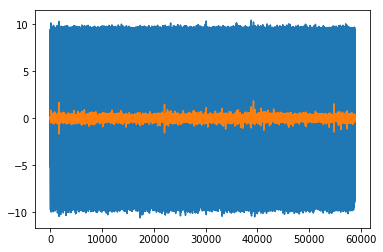

In [8]:
import time
from scipy.optimize import least_squares, minimize

# compute loss value and plot residuals at the initial parameters
if ba_params['opt_K'] and ba_params['fix_K']:
    params_in_K = 3 if cam_model == 'Affine' else 5
    K = cam_params_opt[0,-params_in_K:]
    cam_params_opt2 = np.hstack([cam_params_opt[cam_id, :-params_in_K] for cam_id in range(n_cam)])
    cam_params_opt2 = np.hstack((K, cam_params_opt2))
    x0 = np.hstack((cam_params_opt2.ravel(), pts_3d_opt.ravel()))
else:
    x0 = np.hstack((cam_params_opt.ravel(), pts_3d_opt.ravel()))
f0 = ba_utils.fun(x0, cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params, pts_2d_w)
plt.plot(f0)

# define jacobian
A = ba_utils.bundle_adjustment_sparsity(cam_ind, pts_ind, ba_params)

# run bundle adjustment
t0 = time.time()
res = least_squares(ba_utils.fun, x0, jac_sparsity=A, verbose=2, x_scale='jac',
                    method='trf', ftol=1e-4, xtol=1e-8, loss='soft_l1', f_scale = 0.5,
                    args=(cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params, pts_2d_w))

t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba, cam_params_ba, P_crop_ba = ba_utils.get_ba_output(res.x, ba_params, properR_axis, cam_params, pts_3d)

### Check BA error

Error before BA (mean / median): 11.12 / 11.92
Error after  BA (mean / median): 0.18 / 0.14


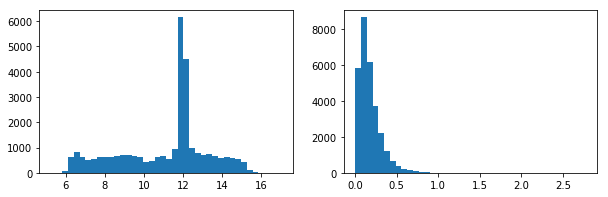

In [9]:
# check BA error performance

des_norm = np.repeat(pts_2d_w,2, axis=0)

init_e = np.sort(np.add.reduceat(abs(f0.astype(float)/des_norm), np.arange(0, len(f0), 2)))
init_e_mean = np.mean(init_e)
init_e_median = np.median(init_e)

ba_e = np.sort(np.add.reduceat(abs(res.fun.astype(float)/des_norm), np.arange(0, len(res.fun), 2)))
ba_e_mean = np.mean(ba_e)
ba_e_median = np.median(ba_e)

print('Error before BA (mean / median): {:.2f} / {:.2f}'.format(init_e_mean, init_e_median))
print('Error after  BA (mean / median): {:.2f} / {:.2f}'.format(ba_e_mean, ba_e_median))

_,f = plt.subplots(1, 2, figsize=(10,3))
f[0].hist(init_e, bins=40); 
f[1].hist(ba_e, bins=40); 

### Check reprojection error before and after Bundle Adjustment

 ----> Real 2D loc in im 0  (sol) =  [ 521.488281 1535.3573  ]
 ----> Proj 2D loc in im 0  before BA =  [ 515.96620969 1528.60056542]
 ----> Proj 2D loc in im 0  after  BA =  [ 521.49695097 1535.42974344]
              Reprojection error beofre BA: 12.278805886620148
              Reprojection error after  BA: 0.08111340581854165
 ----> Real 2D loc in im 1  (sol) =  [ 465.413513 1583.036011]
 ----> Proj 2D loc in im 1  before BA =  [ 467.99052099 1592.54777802]
 ----> Proj 2D loc in im 1  after  BA =  [ 465.38240374 1583.15121607]
              Reprojection error beofre BA: 12.088775013411748
              Reprojection error after  BA: 0.14631433392906956
 ----> Real 2D loc in im 2  (sol) =  [ 416.394287 1638.035278]
 ----> Proj 2D loc in im 2  before BA =  [ 410.23664411 1634.99451598]
 ----> Proj 2D loc in im 2  after  BA =  [ 416.41618564 1637.8436376 ]
              Reprojection error beofre BA: 9.198404912329693
              Reprojection error after  BA: 0.2135390353943194

ECEF 

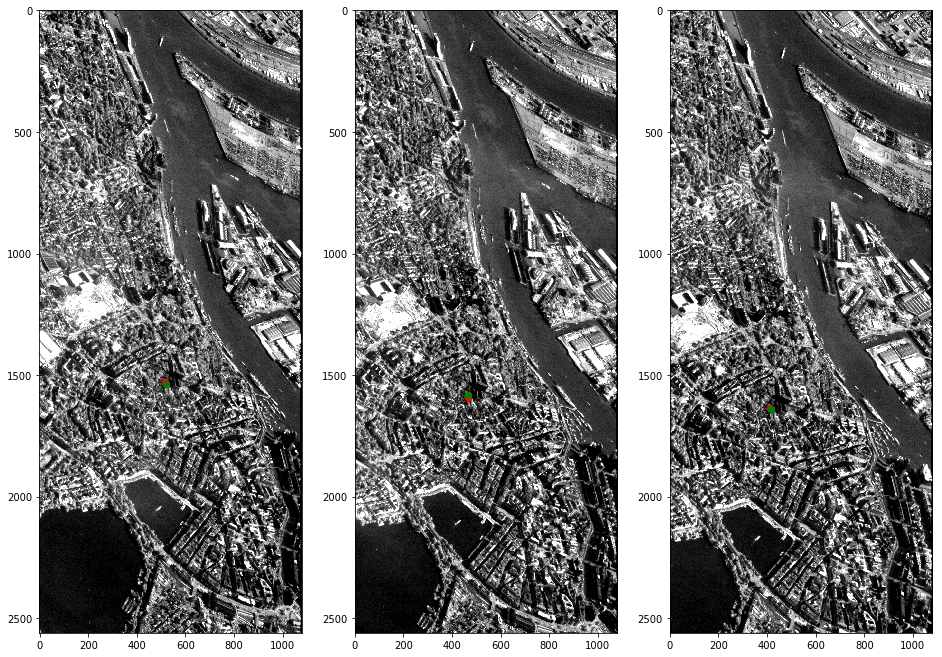

In [11]:
n_pts = C.shape[1]
#p_ind = pts_ind[np.argmax(np.add.reduceat(abs(f0), np.arange(0, len(f0), 2)))] # idx of observation with max error
p_ind = np.random.choice(np.arange(0,n_pts))
im_ind = [k for k, j in enumerate(range(n_cam)) if not np.isnan(C[j*2,p_ind])]
reprojection_error, reprojection_error_ba  = 0., 0.
cont = -1
_,f = plt.subplots(1, len(im_ind), figsize=(16,12))
                                           
for i in im_ind:   
    cont += 1
    
    p_2d_gt = C[(i*2):(i*2+2),p_ind]
    
    proj = P_crop_ba[i] @ np.expand_dims(np.hstack((pts_3d_ba[p_ind,:], np.ones(1))), axis=1)
    p_2d_proj_ba = proj[0:2,:] / proj[-1,-1]
    proj = P_crop[i] @ np.expand_dims(np.hstack((pts_3d[p_ind,:], np.ones(1))), axis=1)
    p_2d_proj = proj[0:2,:] / proj[-1,-1]
    
    #if cont == 0:
        #print('3D location (initial)  :', pts_3d[p_ind,:].ravel())
        #print('3D location (after BA) :', pts_3d_ba[p_ind,:].ravel(), '\n')
    
    print(' ----> Real 2D loc in im', i, ' (sol) = ', p_2d_gt)
    print(' ----> Proj 2D loc in im', i, ' before BA = ', p_2d_proj.ravel())
    print(' ----> Proj 2D loc in im', i, ' after  BA = ', p_2d_proj_ba.ravel())
    print('              Reprojection error beofre BA:', np.sum(abs(p_2d_proj.ravel() - p_2d_gt)))
    print('              Reprojection error after  BA:', np.sum(abs(p_2d_proj_ba.ravel() - p_2d_gt)))
    
    f[cont].imshow(mycrops[i]['crop'].T, cmap="gray")
    f[cont].plot(*p_2d_gt, "yo")
    f[cont].plot(*p_2d_proj, "ro")
    #f[cont].plot(*p_2d_gt[::-1], "yo")
    #f[cont].plot(*p_2d_proj[::-1], "ro")    
    f[cont].plot(*p_2d_proj_ba, "go")
    
print('\nECEF coordinates of the 3D point:', pts_3d_ba[p_ind])

lat, lon, h = ba_utils.ecef_to_latlon_custom(x=pts_3d_ba[p_ind,0], y=pts_3d_ba[p_ind,1], z=pts_3d_ba[p_ind,2])
print('lat, lon: [{:.3f}, {:.3f}], alt: {:.3f}'.format(lat, lon, h))

### Do the 3D points fall in the correct place?

Verify that the projection of the bounding box containing the point cloud of the scene falls in the correct area of the Earth.

In [12]:
lat, lon, alt = ba_utils.ecef_to_latlon_custom(pts_3d_ba[:,0], pts_3d_ba[:,1], pts_3d_ba[:,2])

mymap = vistools.clickablemap(zoom=12)
## set the coordinates of the area of interest as a GeoJSON polygon
aoi = {'coordinates': [[[min(lon), min(lat)], [min(lon), max(lat)], 
                        [max(lon), max(lat)], [max(lon), min(lat)],
                        [min(lon), min(lat)]]], 'type': 'Polygon'}
# set the center of the aoi
aoi['center'] = np.mean(aoi['coordinates'][0][:4], axis=0).tolist()
# display a polygon covering the aoi and center the map
mymap.add_GeoJSON(aoi) 
mymap.center = aoi['center'][::-1]
mymap.zoom = 15         
display(mymap)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### Detailed view of initial-final reprojection errors for a particular image

This can be used to analyse a particular image in detail.

image 0, mean abs reproj error before BA: 12.9729
image 0, mean abs reproj error after  BA: 0.1679


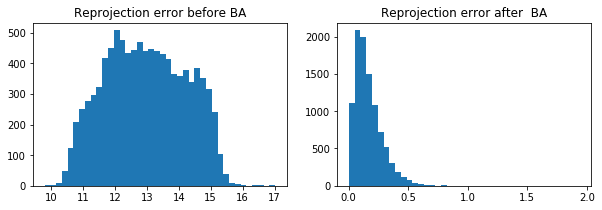

In [13]:
# set the index of the image to analyse
im_idx = 0

# pick all points visible in the selected image

pts_gt = C[(im_idx*2):(im_idx*2+2),~np.isnan(C[im_idx*2,:])].T
pts_3d_before = pts_3d[~np.isnan(C[im_idx*2,:]),:]
pts_3d_after = pts_3d_ba[~np.isnan(C[im_idx*2,:]),:]

# reprojections before bundle adjustment
proj = P_crop[im_idx] @ np.hstack((pts_3d_before, np.ones((pts_3d_before.shape[0],1)))).T
pts_reproj_before = (proj[:2,:]/proj[-1,:]).T

# reprojections after bundle adjustment
proj = P_crop_ba[im_idx] @ np.hstack((pts_3d_after, np.ones((pts_3d_after.shape[0],1)))).T
pts_reproj_after = (proj[:2,:]/proj[-1,:]).T

err_before = np.sum(abs(pts_reproj_before - pts_gt), axis=1)
err_after = np.sum(abs(pts_reproj_after - pts_gt), axis=1)

print('image {}, mean abs reproj error before BA: {:.4f}'.format(im_idx, np.mean(err_before)))
print('image {}, mean abs reproj error after  BA: {:.4f}'.format(im_idx, np.mean(err_after)))

# reprojection error histograms for the selected image
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('Reprojection error before BA')
ax2.title.set_text('Reprojection error after  BA')
ax1.hist(err_before, bins=40); 
ax2.hist(err_after, bins=40);

plt.show()

Simple visualization. Green crosses represent the detected feature tracks, and red vectors are the distance to the reprojected point locations. 

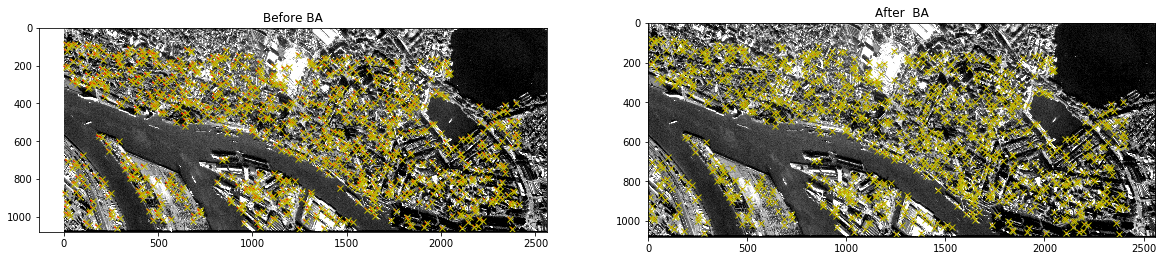

In [23]:
# warning: this is slow...

fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('Before BA')
ax2.title.set_text('After  BA')
ax1.imshow((mycrops[im_idx]['crop']), cmap="gray")
ax2.imshow((mycrops[im_idx]['crop']), cmap="gray")
for k in range(pts_gt.shape[0]):
    # before bundle adjustment
    ax1.plot([pts_gt[k,1], pts_reproj_before[k,1] ], [pts_gt[k,0], pts_reproj_before[k,0]], 'r-')
    ax1.plot(*pts_gt[k][::-1], 'yx')
    # after bundle adjustment
    ax2.plot([pts_gt[k,1], pts_reproj_after[k,1] ], [pts_gt[k,0], pts_reproj_after[k,0]], 'r-')
    ax2.plot(*pts_gt[k][::-1], 'yx')
plt.show()

### Check the distance between the projection rays of two cameras

This gives an idea of the error in the traingulation of points before and after Bundle Adjustment.

Checking the distance between projection rays...
...done!



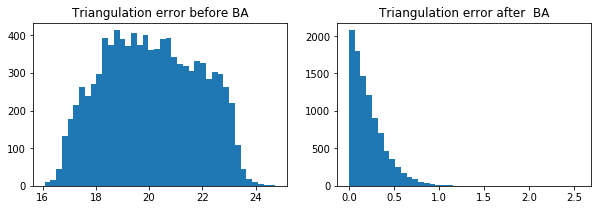

In [19]:
from PIL import Image

print('Checking the distance between projection rays...')

im1, im2 = 0,1

# get SIFT keypoints visible in both images
visible_idx = np.logical_and(~np.isnan(C[im1*2,:]), ~np.isnan(C[im2*2,:])) 
pts1, pts2 = C[(im1*2):(im1*2+2), visible_idx], C[(im2*2):(im2*2+2), visible_idx]
tr_err, tr_err_ba = [],[]
pts_3d_sift, pts_3d_sift_ba = np.zeros((pts1.shape[1], 3)), np.zeros((pts1.shape[1], 3))

triangulate_err_hist = True 
triangulate_err_dsm  = False

# triangulate and compute triangulation error (i.e. distance between projection rays)
for n in range(pts1.shape[1]):
    pt1, pt2 = pts1[:,n].ravel(), pts2[:,n].ravel()
    # before bundle adjustment
    pts_3d_sift[n,:] = ba_utils.linear_triangulation_single_pt(pt1, pt2, P_crop[im1], P_crop[im2])
    tr_err.append(ba_utils.dist_between_proj_rays(pt1, pt2, P_crop[im1], P_crop[im2]))
    # after bundle adjustment
    pts_3d_sift_ba[n,:] = ba_utils.linear_triangulation_single_pt(pt1, pt2, P_crop_ba[im1], P_crop_ba[im2])
    tr_err_ba.append(ba_utils.dist_between_proj_rays(pt1, pt2, P_crop_ba[im1], P_crop_ba[im2]))

if triangulate_err_hist:
    fig = plt.figure(figsize=(10,3))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.title.set_text('Triangulation error before BA')
    ax2.title.set_text('Triangulation error after  BA')
    ax1.hist(tr_err, bins=40); 
    ax2.hist(tr_err_ba, bins=40);
    
# project dsm of the cloud but instead of projecting the height, project the triangulation error
if triangulate_err_dsm:
    # before bundle adjustment
    x , y, z = pts_3d_sift[:,0], pts_3d_sift[:,1], pts_3d_sift[:,2]
    lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
    east, north = utils.utm_from_lonlat(lon, lat)
    xyz = np.vstack((east, north, tr_err)).T
    _, dem_nan, _ = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=10.0)
    im = Image.fromarray(dem_nan)
    im.save(input_dir+'/triangulate_{}_{}.tif'.format(im1,im2))
    # after bundle adjustment
    x , y, z = pts_3d_sift_ba[:,0], pts_3d_sift_ba[:,1], pts_3d_sift_ba[:,2]
    lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
    east, north = utils.utm_from_lonlat(lon, lat)
    xyz = np.vstack((east, north, tr_err_ba)).T
    _, dem_nan, _ = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=10.0)
    im = Image.fromarray(dem_nan)
    im.save(input_dir+'/triangulate_{}_{}_ba.tif'.format(im1,im2))
    
print('...done!\n')

### Save point clouds of SIFT keypoints before and after Bundle Adjustment 

In [20]:
print('Writing point clouds of SIFT keypoints...')

if not os.path.isdir(input_dir+'/sift_clouds_before'):
    os.mkdir(input_dir+'/sift_clouds_before')
if not os.path.isdir(input_dir+'/sift_clouds_after'):
    os.mkdir(input_dir+'/sift_clouds_after')

n_cam = int(C.shape[0]/2)
for im1 in range(n_cam):
    for im2 in range(im1+1, n_cam):
        
        # get SIFT keypoints visible in both images
        visible_idx = np.logical_and(~np.isnan(C[im1*2,:]), ~np.isnan(C[im2*2,:])) 
        pts1, pts2 = C[(im1*2):(im1*2+2), visible_idx], C[(im2*2):(im2*2+2), visible_idx]
        
        # triangulation of SIFT keypoints before bundle adjustment
        pts_3d_sift = ba_utils.triangulate_list_of_matches(pts1, pts2, P_crop[im1], P_crop[im2])
        x , y, z = pts_3d_sift[:,0], pts_3d_sift[:,1], pts_3d_sift[:,2]
        lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T
        fn = input_dir+'/sift_clouds_before/{:02}_{:02}.ply'.format(im1, im2)
        ba_utils.write_point_cloud_ply(fn, xyz, color=np.random.choice(range(256), size=3))
        
        # triangulation of SIFT keypoints after bundle adjustment
        pts_3d_sift = ba_utils.triangulate_list_of_matches(pts1, pts2, P_crop_ba[im1], P_crop_ba[im2])
        x , y, z = pts_3d_sift[:,0], pts_3d_sift[:,1], pts_3d_sift[:,2]
        lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T
        fn = input_dir+'/sift_clouds_after/{:02}_{:02}_ba.ply'.format(im1, im2)
        ba_utils.write_point_cloud_ply(fn, xyz, color=np.random.choice(range(256), size=3))
        
print('...done!\n')

Writing point clouds of SIFT keypoints...
...done!

